# **Product Reviews Analysis**


**Introduction**

Product reviews provide valuable feedback from customers that can influence buying decisions and product improvements. However, reviews vary widely in length, sentiment, and helpfulness, making it important to analyze these patterns. This project analyzes a large dataset of product reviews to uncover insights about customer feedback trends, reviewer behavior, and product performance over time.

🎯 **Project Objectives:**

 - Understand the distribution and characteristics of review scores and lengths

 - Explore the relationship between helpfulness votes and review content

 - Identify temporal trends in reviews over the years

 - Examine differences in review length across score categories

 - Investigate associations between product types and review scores

 - Perform hypothesis testing to validate observed patterns and dependencies

 - Provide actionable insights to improve product strategy and customer engagement

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway, chi2_contingency
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

In [176]:
# Load the dataset
df = pd.read_csv(r'/content/Reviews.csv')
print("Shape:", df.shape)

Shape: (568454, 10)


In [177]:
df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [178]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB
None


# **Data Cleaning**

In [179]:
# Check for duplicates
print("\nDuplicate rows (exact):", df.duplicated().sum())


Duplicate rows (exact): 0


In [180]:
# Check for missing data
missing = df.isnull().sum().sort_values(ascending=False)
print("\nMissing values:\n", missing)


Missing values:
 Summary                   27
ProfileName               26
ProductId                  0
Id                         0
HelpfulnessNumerator       0
UserId                     0
HelpfulnessDenominator     0
Score                      0
Time                       0
Text                       0
dtype: int64


In [181]:
df['Time'] = pd.to_datetime(df['Time'], unit='s', errors='coerce')

In [182]:
# Helpfulness ratio (handling 0 denominator)
df['HelpfulnessDenominator'] = df['HelpfulnessDenominator'].fillna(0).astype(int)
df['HelpfulnessNumerator'] = df['HelpfulnessNumerator'].fillna(0).astype(int)
df['helpful_ratio'] = np.where(df['HelpfulnessDenominator'] > 0,
                               df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'],np.nan)

In [183]:
df['Text'] = df['Text'].fillna('')

In [184]:
df['ReviewLength'] = df['Text'].str.len()

In [185]:
# Time-derived features
if 'Time' in df.columns:
    df['year'] = df['Time'].dt.year
    df['month'] = df['Time'].dt.month
    df['ym'] = df['Time'].dt.to_period('M')
    df['review_age_days'] = (df['Time'].max() - df['Time']).dt.days

In [186]:
print("\nDescriptive Stats (Numeric):\n", df.describe())


Descriptive Stats (Numeric):
                   Id  HelpfulnessNumerator  HelpfulnessDenominator  \
count  568454.000000         568454.000000            568454.00000   
mean   284227.500000              1.743817                 2.22881   
min         1.000000              0.000000                 0.00000   
25%    142114.250000              0.000000                 0.00000   
50%    284227.500000              0.000000                 1.00000   
75%    426340.750000              2.000000                 2.00000   
max    568454.000000            866.000000               923.00000   
std    164098.679298              7.636513                 8.28974   

               Score                           Time  helpful_ratio  \
count  568454.000000                         568454  298402.000000   
mean        4.183199  2011-01-28 23:16:44.902419712       0.776975   
min         1.000000            1999-10-08 00:00:00       0.000000   
25%         4.000000            2010-04-15 00:00:00       

# **Exploratory Data Analysis**

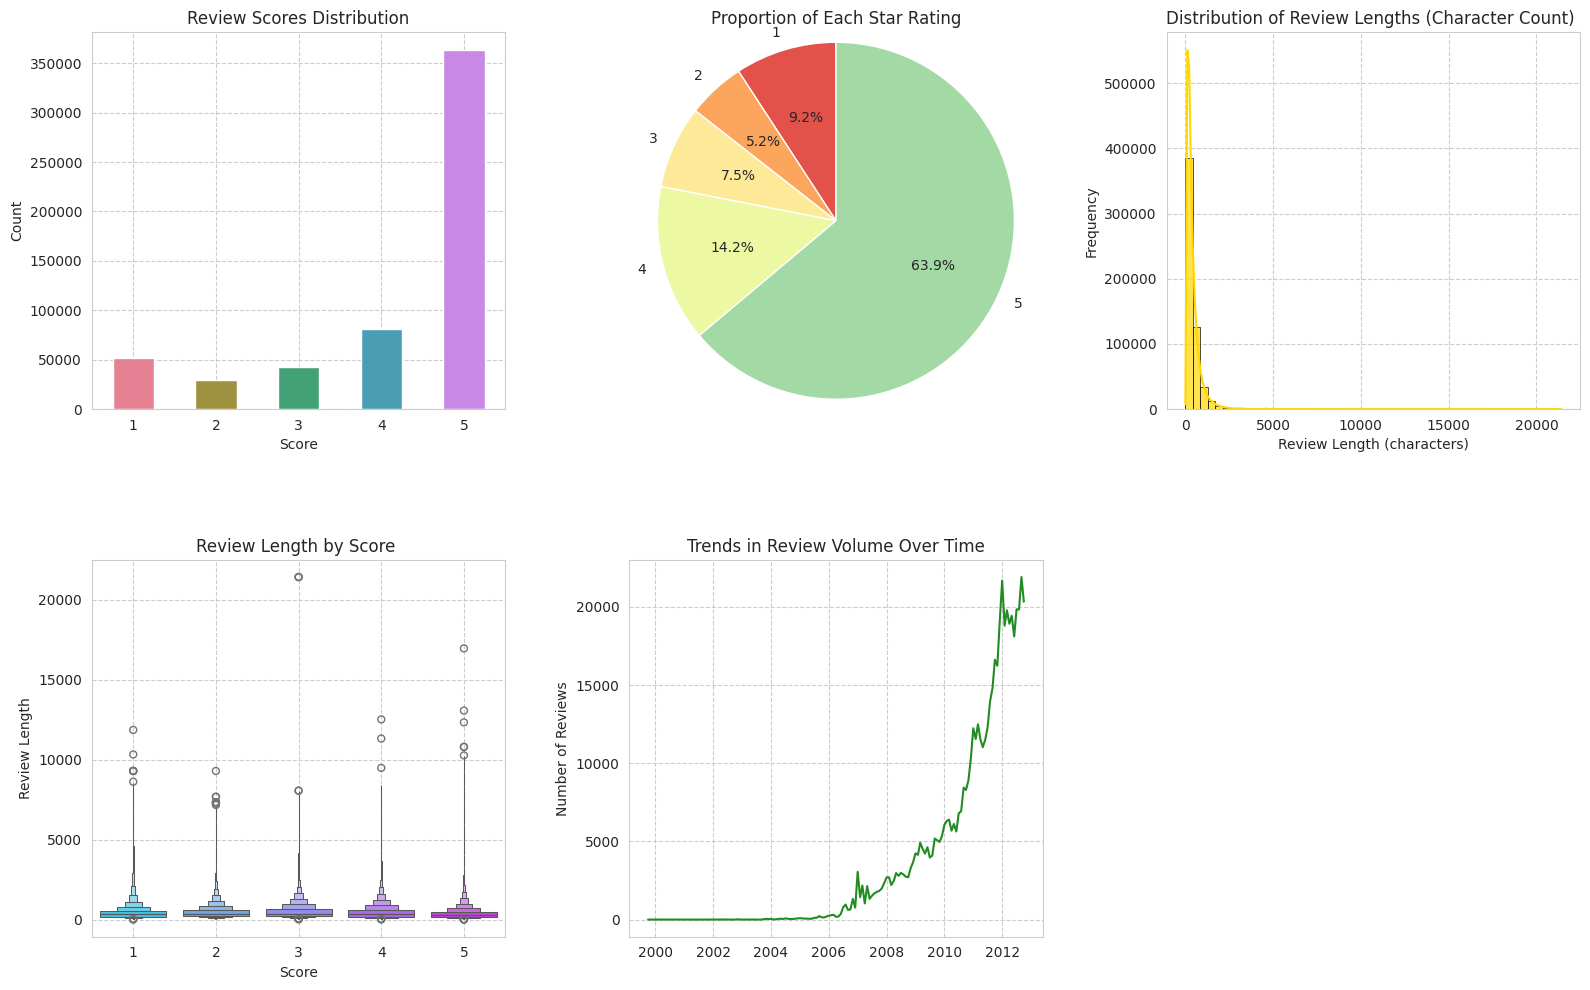

In [187]:
score_counts = df['Score'].value_counts().sort_index()

plt.figure(figsize=(16, 10))

plt.subplot(2, 3, 1)
sns.countplot(x='Score', data=df, palette='husl',width=0.5)
plt.title("Review Scores Distribution")
plt.xlabel("Score")
plt.ylabel("Count")
plt.grid(linestyle='--')

plt.subplot(2, 3, 2)
plt.pie(score_counts, labels=score_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Spectral'))
plt.axis('equal')
plt.title("Proportion of Each Star Rating")

plt.subplot(2, 3, 3)
sns.histplot(df['ReviewLength'], bins=50, kde=True, color='gold',alpha=0.7,edgecolor='black')
plt.title("Distribution of Review Lengths (Character Count) ")
plt.xlabel("Review Length (characters)")
plt.ylabel("Frequency")
plt.grid(linestyle='--')

plt.subplot(2, 3, 4)
sns.boxenplot(x='Score', y='ReviewLength', data=df, palette='cool')
plt.title("Review Length by Score ")
plt.xlabel("Score")
plt.ylabel("Review Length")
plt.grid(linestyle='--')

plt.subplot(2, 3, 5)
monthly_counts = df.groupby(df['Time'].dt.to_period("M")).size()
monthly_counts.index = monthly_counts.index.to_timestamp()
plt.plot(monthly_counts.index, monthly_counts.values, color='forestgreen')
plt.title("Trends in Review Volume Over Time")
plt.ylabel("Number of Reviews")
plt.grid(linestyle='--')

plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

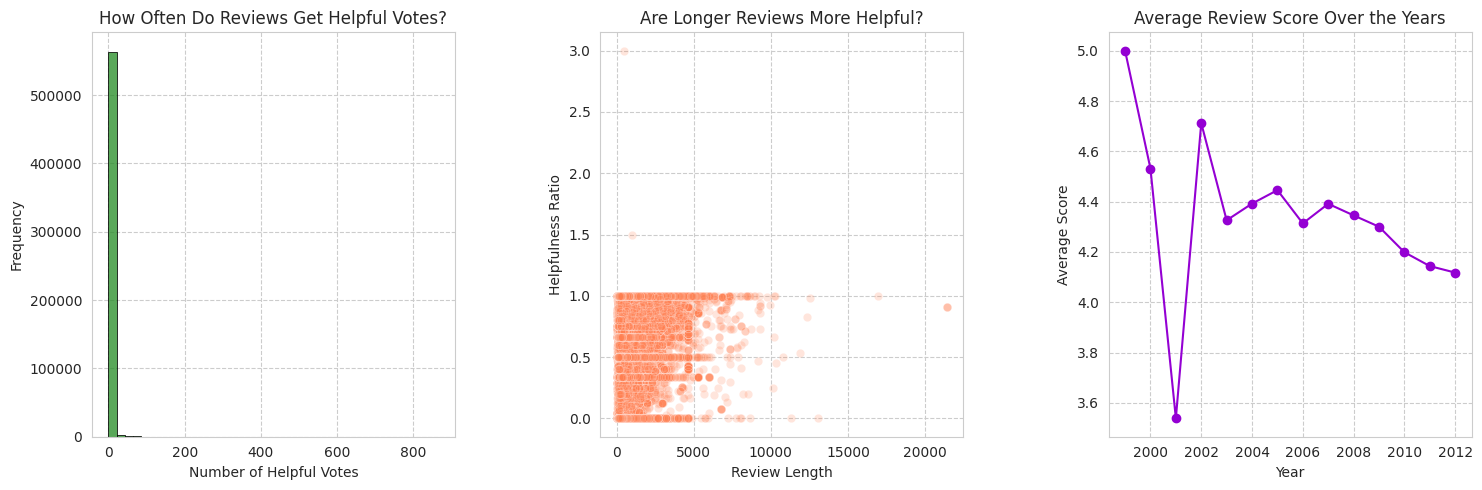

In [189]:
plt.figure(figsize=(20, 5))

# Helpful votes distribution
plt.subplot(1, 4, 1)
sns.histplot(df['HelpfulnessNumerator'], bins=40, color='forestgreen', edgecolor='black')
plt.title("How Often Do Reviews Get Helpful Votes?")
plt.xlabel("Number of Helpful Votes")
plt.ylabel("Frequency")
plt.grid(linestyle='--')

# Helpful ratio vs Review Length (only for non-null helpful_ratio)
plt.subplot(1, 4, 2)
sns.scatterplot(x='ReviewLength', y='helpful_ratio', data=df[df['helpful_ratio'].notna()],alpha=0.2, color='coral')
plt.title("Are Longer Reviews More Helpful?")
plt.xlabel("Review Length")
plt.ylabel("Helpfulness Ratio")
plt.grid(linestyle='--')

# Average score by year
plt.subplot(1, 4, 3)
avg_score_year = df.groupby('year')['Score'].mean()
plt.plot(avg_score_year.index, avg_score_year.values, marker='o', color='darkviolet')
plt.title("Average Review Score Over the Years")
plt.xlabel("Year")
plt.ylabel("Average Score")
plt.grid(linestyle='--')


plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
plt.show()


Top 10 Products Review Stats:


,reviews,median_score,mean_review_length,helpful_votes
ProductId,,,,
B007JFMH8M,913,5.0,284.684556,41
B0026RQTGE,632,5.0,322.939873,611
B002QWP8H0,632,5.0,322.939873,611
B002QWHJOU,632,5.0,322.939873,611
B002QWP89S,632,5.0,322.939873,611
B003B3OOPA,623,5.0,476.666132,2944
B001EO5Q64,567,5.0,502.626102,1947
B0013NUGDE,564,5.0,412.418440,488
B007M832YY,564,5.0,412.418440,488


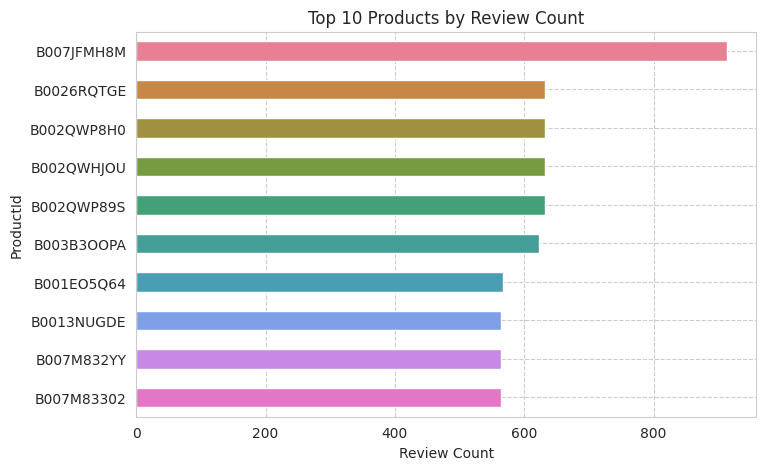

In [190]:
# Top 10 Products Review Stats
top_products = df['ProductId'].value_counts().head(10).index
prod_stats = df[df['ProductId'].isin(top_products)].groupby('ProductId').agg(
    reviews=('Id','count'),
    median_score=('Score','median'),
    mean_review_length=('ReviewLength','mean'),
    helpful_votes=('HelpfulnessNumerator','sum')
).sort_values('reviews', ascending=False)

print("\nTop 10 Products Review Stats:")
display(prod_stats)

plt.figure(figsize=(8,5))
sns.barplot(x=prod_stats['reviews'], y=prod_stats.index, palette='husl', width=0.5)
plt.title("Top 10 Products by Review Count")
plt.xlabel("Review Count")
plt.ylabel("ProductId")
plt.grid(linestyle='--')
plt.show()

In [191]:
# Top reviewers by number of reviews
top_reviewers = df['UserId'].value_counts().head(10)
print("\nTop 10 Reviewers by Review Count:")
display(top_reviewers)


Top 10 Reviewers by Review Count:


,count
UserId,
A3OXHLG6DIBRW8,448
A1YUL9PCJR3JTY,421
AY12DBB0U420B,389
A281NPSIMI1C2R,365
A1Z54EM24Y40LL,256
A1TMAVN4CEM8U8,204
A2MUGFV2TDQ47K,201
A3TVZM3ZIXG8YW,199
A3PJZ8TU8FDQ1K,178


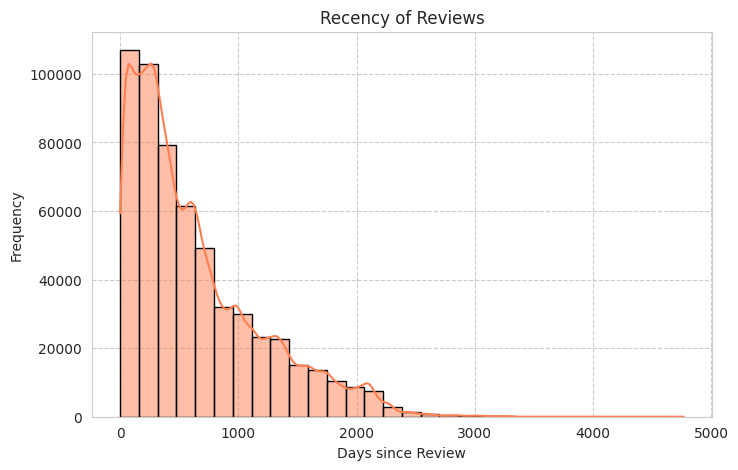

In [192]:
# Days since review
plt.figure(figsize=(8,5))
sns.histplot(df['review_age_days'], bins=30, kde=True, color='coral', edgecolor='black')
plt.title("Recency of Reviews")
plt.xlabel("Days since Review")
plt.ylabel("Frequency")
plt.grid(linestyle='--')
plt.show()

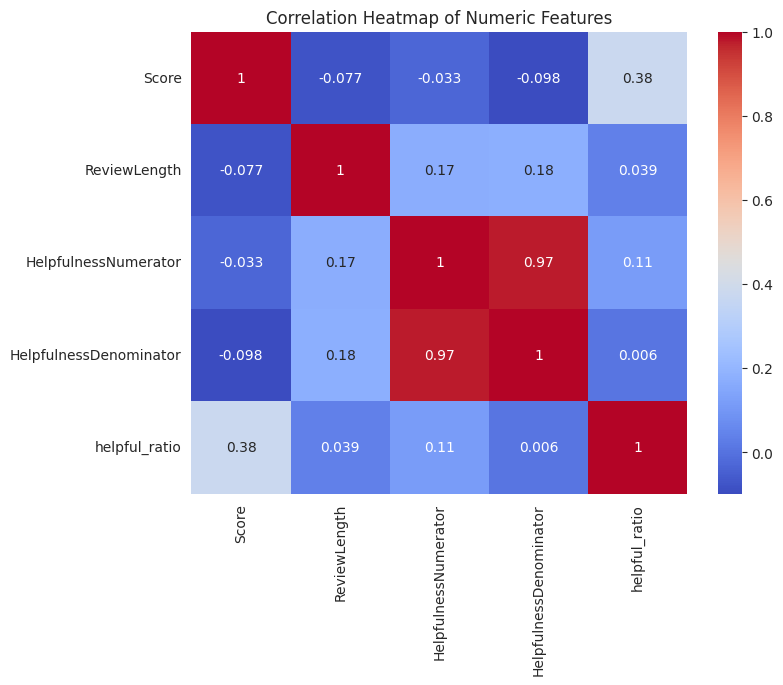

In [193]:
# Correlation Analysis
plt.figure(figsize=(8,6))
sns.heatmap(df[['Score', 'ReviewLength', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'helpful_ratio']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# **Hypothesis Testing**

In [145]:
alpha = 0.05

In [194]:
# 1. T-test: Compare text length between 5-star and 1-star reviews
five_star = df[df['Score'] == 5]['ReviewLength']
one_star = df[df['Score'] == 1]['ReviewLength']
t_stat, p_val = ttest_ind(five_star, one_star, equal_var=False)
print("\nT-Test: Review Length Comparison between 5-star and 1-star Reviews")
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.4f}")
if p_val < alpha:
    print("Result: Significant difference in review length between 5-star and 1-star reviews.")
else:
    print("Result: No significant difference in review length between 5-star and 1-star reviews.")


T-Test: Review Length Comparison between 5-star and 1-star Reviews
T-statistic: -31.831
P-value: 0.0000
Result: Significant difference in review length between 5-star and 1-star reviews.


In [195]:
# 2. ANOVA: Compare review length across ALL scores
groups = [df[df['Score'] == s]['ReviewLength'] for s in sorted(df['Score'].unique())]
f_stat, p_val_anova = f_oneway(*groups)
print("\nANOVA Test: Review Length Across All Score Categories")
print(f"F-statistic: {f_stat:.3f}")
print(f"P-value: {p_val_anova:.4f}")
if p_val_anova < alpha:
    print("Result: Review length varies significantly across all score categories.")
else:
    print("Result: No significant difference in review length across score categories.")


ANOVA Test: Review Length Across All Score Categories
F-statistic: 1515.578
P-value: 0.0000
Result: Review length varies significantly across all score categories.


In [196]:
# 3. Chi-Square Test: Check dependency between product and score
if 'ProductId' in df.columns:
    contingency = pd.crosstab(df['ProductId'], df['Score'])
    chi2, p, dof, expected = chi2_contingency(contingency)
    print("\nChi-Square Test: Association between ProductId and Score")
    print(f"Chi2 Statistic: {chi2:.3f}")
    print(f"P-value: {p:.4f}")
    if p < alpha:
        print("Result: Product type and score are statistically dependent.")
    else:
        print("Result: Product type and score are independent.")


Chi-Square Test: Association between ProductId and Score
Chi2 Statistic: 388440.016
P-value: 0.0000
Result: Product type and score are statistically dependent.


# **Key Insights**

In [197]:
print("\n=== 📊 KEY INSIGHTS FROM ANALYSIS ===\n")

total_reviews = f"{df.shape[0]:,}"
common_score = df['Score'].mode()[0]
median_length = df['ReviewLength'].median()
avg_help_ratio = df['helpful_ratio'].mean()
top_product = prod_stats.index[0]
top_product_reviews = f"{prod_stats.reviews.iloc[0]:,}"
top_reviewer_reviews = f"{top_reviewers.iloc[0]:,}"
corr = df['Score'].corr(df['ReviewLength'])

if corr > 0:
    direction = "higher"
elif corr < 0:
    direction = "lower"
else:
    direction = "neither higher nor lower"

print(f"- This dataset contains {total_reviews} product reviews.")
print(f"- The most common rating is {common_score} stars, indicating a generally {'positive' if common_score>=4 else 'mixed/negative'} bias.")
print(f"- Reviews have a median length of {median_length} characters.")
print(f"- The average helpfulness ratio (excluding reviews with zero votes) is {avg_help_ratio:.3f}.")
print(f"- The most-reviewed product is {top_product}, with {top_product_reviews} reviews.")
print(f"- The most active reviewer contributed {top_reviewer_reviews} reviews.")
print(f"- There is a correlation of {corr:.3f} between review length and score, meaning longer reviews tend to receive {direction} ratings.")


=== 📊 KEY INSIGHTS FROM ANALYSIS ===

- This dataset contains 568,454 product reviews.
- The most common rating is 5 stars, indicating a generally positive bias.
- Reviews have a median length of 302.0 characters.
- The average helpfulness ratio (excluding reviews with zero votes) is 0.777.
- The most-reviewed product is B007JFMH8M, with 913 reviews.
- The most active reviewer contributed 448 reviews.
- There is a correlation of -0.077 between review length and score, meaning longer reviews tend to receive lower ratings.
